# Version 2 note:
- Added a few more features, which is the min,max,median,and mean visitors and count observation based on the store id and the day of week. Other features used in v1 will also be included.
- Data transformation method: Label Encoding
- Model used: Random Forest Regressor

# Import Packages

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

%matplotlib inline

# Import Data 

In [25]:
# data folder name
DATA_FOLDER_NAME = 'data/'

# submissions folder name
SUB_FOLDER_NAME = 'submissions/'

# import visitor data
air_visit_data = pd.read_csv(DATA_FOLDER_NAME + 'air_visit_data.csv')

# import air info and date info data
air_store_info = pd.read_csv(DATA_FOLDER_NAME + 'air_store_info.csv')
date_info = pd.read_csv(DATA_FOLDER_NAME + 'date_info.csv')

# import sample submission (use for testing)
submission = pd.read_csv(DATA_FOLDER_NAME + 'sample_submission.csv')

# Preprocessing Data

### Features to include
- month number
- day of week
- holiday flag
- genre
- area name
- is weekend
- min visitors
- max visitors
- median visitors
- mean visitors
- count observations

In [26]:
# adjust the submission file (that will be use to predict and submit) to match the air_visit data
submission['air_store_id'] = submission['id'].str.slice(0, 20)
submission['visit_date'] = submission['id'].str.slice(21)
submission['visitors'] = np.nan
submission['is_for_submission'] = 1

submission.head()

,id,visitors,air_store_id,visit_date,is_for_submission
0,air_00a91d42b08b08d9_2017-04-23,NaN,air_00a91d42b08b08d9,2017-04-23,1
1,air_00a91d42b08b08d9_2017-04-24,NaN,air_00a91d42b08b08d9,2017-04-24,1
2,air_00a91d42b08b08d9_2017-04-25,NaN,air_00a91d42b08b08d9,2017-04-25,1
3,air_00a91d42b08b08d9_2017-04-26,NaN,air_00a91d42b08b08d9,2017-04-26,1
4,air_00a91d42b08b08d9_2017-04-27,NaN,air_00a91d42b08b08d9,2017-04-27,1


In [27]:
 # join both the air visit data and submission records
air_visit_data['is_for_submission'] = 0
full_data = pd.concat((air_visit_data, submission.drop('id',axis='columns')))

c:\program files\python\python35\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
# full data size
full_data.shape

(284127, 4)

In [29]:
full_data.head()

,air_store_id,is_for_submission,visit_date,visitors
0,air_ba937bf13d40fb24,0,2016-01-13,25.0
1,air_ba937bf13d40fb24,0,2016-01-14,32.0
2,air_ba937bf13d40fb24,0,2016-01-15,29.0
3,air_ba937bf13d40fb24,0,2016-01-16,22.0
4,air_ba937bf13d40fb24,0,2016-01-18,6.0


In [30]:
# add store info and date info into the data

# rename calendar date to visit date
date_info.rename(columns={'calendar_date': 'visit_date'}, inplace=True)

# join 2 tables
full_data = pd.merge(left=full_data, right=date_info, on='visit_date', how='left')
full_data = pd.merge(left=full_data, right=air_store_info, on='air_store_id', how='left')

full_data.head()

,air_store_id,is_for_submission,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,0,2016-01-13,25.0,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,0,2016-01-14,32.0,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,0,2016-01-15,29.0,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_ba937bf13d40fb24,0,2016-01-16,22.0,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_ba937bf13d40fb24,0,2016-01-18,6.0,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [31]:
# get the month number, is_weekend
full_data['month_number'] = pd.to_datetime(full_data.visit_date).dt.month
full_data['is_weekend'] = full_data['day_of_week'].isin(['Saturday','Sunday']).astype(int)

In [32]:
# add min, max, mean, median and count observation by store id and day of week
mv = full_data.groupby(['air_store_id','day_of_week'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
full_data = pd.merge(full_data, mv, how='left', on=['air_store_id','day_of_week']) 
mv = full_data.groupby(['air_store_id','day_of_week'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
full_data = pd.merge(full_data, mv, how='left', on=['air_store_id','day_of_week'])
mv = full_data.groupby(['air_store_id','day_of_week'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
full_data = pd.merge(full_data, mv, how='left', on=['air_store_id','day_of_week']) 
mv = full_data.groupby(['air_store_id','day_of_week'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
full_data = pd.merge(full_data, mv, how='left', on=['air_store_id','day_of_week']) 
mv = full_data.groupby(['air_store_id','day_of_week'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
full_data = pd.merge(full_data, mv, how='left', on=['air_store_id','day_of_week']) 


In [33]:
# replace null values
full_data['min_visitors'] = full_data['min_visitors'].fillna(0)
full_data['max_visitors'] = full_data['max_visitors'].fillna(0)
full_data['mean_visitors'] = full_data['mean_visitors'].fillna(0)
full_data['median_visitors'] = full_data['median_visitors'].fillna(0)
full_data['count_observations'] = full_data['count_observations'].fillna(0)

In [34]:
full_data.head()

,air_store_id,is_for_submission,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,longitude,month_number,is_weekend,min_visitors,max_visitors,mean_visitors,median_visitors,count_observations
0,air_ba937bf13d40fb24,0,2016-01-13,25.0,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,0,7.0,57.0,23.843750,25.0,64
1,air_ba937bf13d40fb24,0,2016-01-14,32.0,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,0,2.0,54.0,20.292308,21.0,65
2,air_ba937bf13d40fb24,0,2016-01-15,29.0,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,0,4.0,61.0,34.738462,35.0,65
3,air_ba937bf13d40fb24,0,2016-01-16,22.0,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,1,6.0,53.0,27.651515,27.0,66
4,air_ba937bf13d40fb24,0,2016-01-18,6.0,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,1,0,2.0,34.0,13.754386,12.0,57


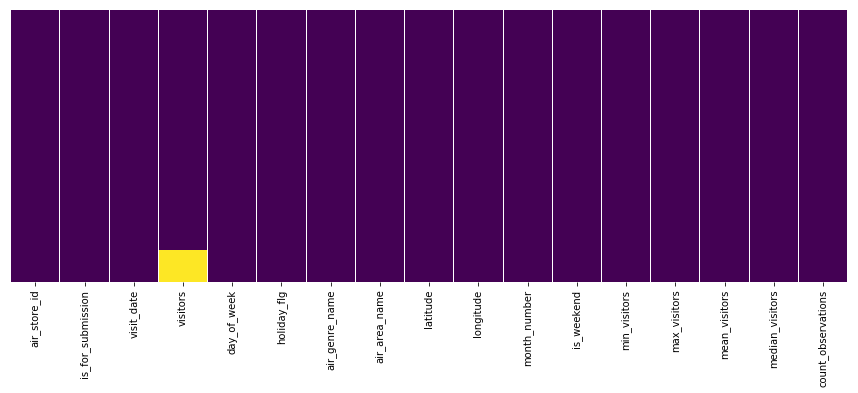

In [35]:
# use heatmap to check if there's any null values apart from visitors, where in submission record, is null value
# * yellow indicate null
plt.figure(figsize=(15,5))
sns.heatmap(full_data.isnull(),yticklabels=False, cbar=False, cmap ='viridis')

# Transform Data

In [37]:
# label encoder
lbl = preprocessing.LabelEncoder()

In [38]:
# transform string categorical columns into numeric categorical columns
full_data['day_of_week'] = lbl.fit_transform(full_data['day_of_week'])
full_data['air_genre_name'] = lbl.fit_transform(full_data['air_genre_name'])
full_data['air_area_name'] = lbl.fit_transform(full_data['air_area_name'])

In [39]:
# split into train data, test data, and data to submit
submit_data = full_data[full_data['is_for_submission']==1]
train_test_data = full_data[full_data['is_for_submission']==0]

In [40]:
# drop unwanted columns
columns_to_drop = ['air_store_id', 'is_for_submission','visit_date','latitude','longitude']

# drop the columns
submit_data = submit_data.drop(columns_to_drop, axis=1)
train_test_data = train_test_data.drop(columns_to_drop, axis=1)

In [41]:
train_test_data.head()

,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,month_number,is_weekend,min_visitors,max_visitors,mean_visitors,median_visitors,count_observations
0,25.0,6,0,4,62,1,0,7.0,57.0,23.843750,25.0,64
1,32.0,4,0,4,62,1,0,2.0,54.0,20.292308,21.0,65
2,29.0,0,0,4,62,1,0,4.0,61.0,34.738462,35.0,65
3,22.0,2,0,4,62,1,1,6.0,53.0,27.651515,27.0,66
4,6.0,1,0,4,62,1,0,2.0,34.0,13.754386,12.0,57


In [42]:
# get X (features) and y (to predict) from train test data
X = train_test_data.drop('visitors', axis=1)
y = train_test_data['visitors']

In [43]:
# train test split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# submit data for testing
X_submit_test = submit_data.drop('visitors', axis=1)

In [44]:
# training size
X_train.shape

(201686, 11)

In [45]:
# test size
X_test.shape

(50422, 11)

# Model to predict


### Random Forest 

In [46]:
# function to calculate RMSLE (Root Mean Square Logarithmic Error)
def RMSLE(y_actual, y_pred) : 
    assert len(y_actual) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_actual))**2))

In [47]:
# random forest regressor
rfc = RandomForestRegressor(n_estimators=100)

In [57]:
# train the data with Random Forest
rfc.fit(X_train, y_train)

# predict the test data with the model
prediction = rfc.predict(X_test)

# calculate the RMSLE
rmsle_score = RMSLE(y_test.values, prediction)
print('RMSLE for Random Forest: ', rmsle_score)

RMSLE for Random Forest:  0.5685812350477276


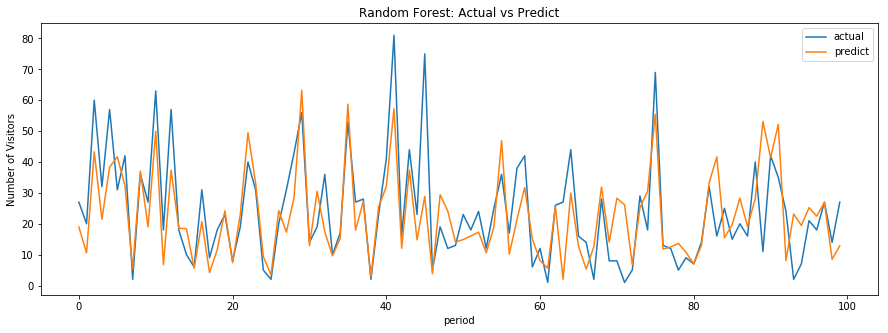

In [58]:
# predict vs actual
# store into dataframe
actual_df = y_test.to_frame().reset_index()
actual_df['index'] = actual_df.index
predict_df = pd.DataFrame(prediction).reset_index()

# top n to display on the plot
n_resu = 100

# plot the first n results
plt.figure(figsize=(15,5))
plt.plot(actual_df['index'].head(n_resu), actual_df['visitors'].head(n_resu), label='actual')
plt.plot(predict_df['index'].head(n_resu), predict_df[0].head(n_resu), label='predict')
plt.ylabel('Number of Visitors')
plt.xlabel('period')
plt.title('Random Forest: Actual vs Predict')
plt.legend(loc='best')

# Important Features 

In [59]:
# show the important features

# convert proportions into dataframe
important_feat_resu = pd.DataFrame(rfc.feature_importances_).reset_index()

# create important features dataframe
important_feat = pd.DataFrame(list(X))
important_feat['proportion'] = important_feat_resu[0]

# rename features
important_feat.rename(columns={0: 'features'}, inplace=True)


important_feat

,features,proportion
0,day_of_week,0.013365
1,holiday_flg,0.010325
2,air_genre_name,0.016293
3,air_area_name,0.024528
4,month_number,0.098169
5,is_weekend,0.004719
6,min_visitors,0.019475
7,max_visitors,0.035863
8,mean_visitors,0.726023
9,median_visitors,0.027838


Text(0.5, 1.0, 'Important Features')

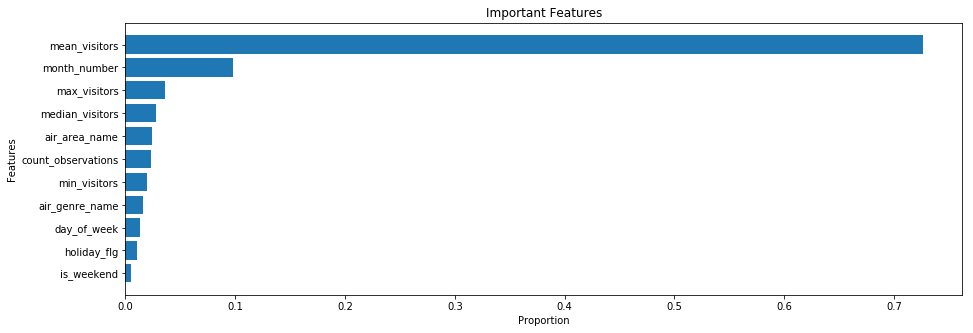

In [60]:
# sort the proportion by descending
important_feat = important_feat.sort_values(by='proportion', ascending=False)

plt.figure(figsize=(15,5))
plt.barh(important_feat['features'],important_feat['proportion'])
plt.gca().invert_yaxis()
plt.xlabel('Proportion')
plt.ylabel('Features')
plt.title('Important Features')


# Test with the submission data 

In [61]:
# test with the submission data
submit_prediction = rfc.predict(X_submit_test)

In [62]:
# convert submit prediction to dataframe
submit_pred_df = pd.DataFrame(submit_prediction).reset_index()

# add results the submission sample file
sub = pd.DataFrame()
sub['id'] = submission['id']
sub['visitors'] = submit_pred_df[0]

In [63]:
# save results into csv file
sub.to_csv(SUB_FOLDER_NAME + 'rf_rmsle_{:.5f}_v2.csv'.format(rmsle_score), index=False)